# Modeling

This notebook will perform modeling of the `Improve` column of the Music Therapy Dataset. Models that will be tested include:
- [Logistic Regression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Gradient Boosting Classifier](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

# Loading Data

The data has been cleaned and preprocessed, and saved as 'pre_processed_survey_results.csv.' All data is numeric, categorical variables have been encoded, and target feature `Improve` has been added. Data types, missingness, and columns will be validated before proceeding with modeling.

In [1]:
# Imports

import pandas as pd
import numpy as np

# ML Libraries

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Visualization
import matplotlib.pyplot as plt

In [2]:
# Set random_state to be used throughout modeling for repeatability

RANDOM_STATE = 75

In [3]:
# Load data and investigate first 5 rows

data = pd.read_csv('./../data/processed/pre_processed_survey_results.csv')

data.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_Jazz,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music
0,18,4.0,0,0,0,0,1,132.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,61,2.5,1,0,1,1,1,84.0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,18,4.0,1,0,0,1,0,107.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,18,5.0,1,1,1,1,1,86.0,1,2,...,1,0,0,0,0,0,0,0,0,0
4,18,3.0,1,1,0,1,1,66.0,2,0,...,0,0,0,0,0,0,0,0,0,1


## Validate Data

In [4]:
# Check columns

data.columns

Index(['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer',
       'Exploratory', 'Foreign languages', 'BPM', 'Frequency [Classical]',
       'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]',
       'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]',
       'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]',
       'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]',
       'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]',
       'Anxiety', 'Depression', 'Insomnia', 'OCD', 'Improve', 'No effect',
       'Worsen', 'fav_Country', 'fav_EDM', 'fav_Folk', 'fav_Gospel',
       'fav_Hip hop', 'fav_Jazz', 'fav_K pop', 'fav_Latin', 'fav_Lofi',
       'fav_Metal', 'fav_Pop', 'fav_R&B', 'fav_Rap', 'fav_Rock',
       'fav_Video game music'],
      dtype='object')

In [5]:
# Check datatypes

data.dtypes

Age                               int64
Hours per day                   float64
While working                     int64
Instrumentalist                   int64
Composer                          int64
Exploratory                       int64
Foreign languages                 int64
BPM                             float64
Frequency [Classical]             int64
Frequency [Country]               int64
Frequency [EDM]                   int64
Frequency [Folk]                  int64
Frequency [Gospel]                int64
Frequency [Hip hop]               int64
Frequency [Jazz]                  int64
Frequency [K pop]                 int64
Frequency [Latin]                 int64
Frequency [Lofi]                  int64
Frequency [Metal]                 int64
Frequency [Pop]                   int64
Frequency [R&B]                   int64
Frequency [Rap]                   int64
Frequency [Rock]                  int64
Frequency [Video game music]      int64
Anxiety                           int64


In [6]:
# Check missing values

data.isna().sum()

Age                             0
Hours per day                   0
While working                   0
Instrumentalist                 0
Composer                        0
Exploratory                     0
Foreign languages               0
BPM                             0
Frequency [Classical]           0
Frequency [Country]             0
Frequency [EDM]                 0
Frequency [Folk]                0
Frequency [Gospel]              0
Frequency [Hip hop]             0
Frequency [Jazz]                0
Frequency [K pop]               0
Frequency [Latin]               0
Frequency [Lofi]                0
Frequency [Metal]               0
Frequency [Pop]                 0
Frequency [R&B]                 0
Frequency [Rap]                 0
Frequency [Rock]                0
Frequency [Video game music]    0
Anxiety                         0
Depression                      0
Insomnia                        0
OCD                             0
Improve                         0
No effect     

Since `Improve`, `No effect`, and `Worsen` are collinear, `Worsen` will be dropped. Otherwise combination of the three would be able to perfectly predict `Improve`.

In [7]:
# Drop Worsen column

data = data.drop(['Worsen', 'No effect'], axis=1)

print('Worsen' in data.columns or 'No effect' in data.columns)

False


## Split Data

Data will be split into `X` and `y`, where `y` is the `Improve` column and `X` is the rest of the features.

In [8]:
# Split into X and y, then training and testing

X = data.drop('Improve', axis=1)
y = data['Improve']

# Split into training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_STATE)

# Hyperparameter Tuning

Before comparing the results of our three models, we'll perform some hyperparameter tuning to generate the best models for our data.

In [9]:
# Set up scaling for continuous variables

numeric_cols = ['Age', 'BPM', 'Hours per day']
categorical_cols = [col for col in X if col not in numeric_cols]

preprocesser = ColumnTransformer(
    transformers = [
        ('numeric', StandardScaler(), numeric_cols),
        ('categorical', 'passthrough', categorical_cols)
    ]
)

# Set up KFold for cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Logistic Regression

In [10]:
# Set up pipeline

steps = [
    ('preprocessor', preprocesser),
    ('classifier', LogisticRegression(max_iter=3000))
]

pipeline = Pipeline(steps)

# Set up hyperparameter tuning parameters

param_grid = {
    'classifier__penalty' : ['elasticnet', 'l2', 'l1'],
    'classifier__C' : np.linspace(0, 4, 10),
    'classifier__solver' : ['lbfgs', 'liblinear', 'saga']
}

# Perform hyperparameter tuning
lr_cv = GridSearchCV(pipeline, param_grid, cv=kf, n_jobs=-1)
lr_cv.fit(X_train, y_train)

# Print results

print(f"Mean accuracy score: {round(lr_cv.best_score_, 2)}")
print(f"Best parameters: {lr_cv.best_params_}")

Mean accuracy score: 0.75
Best parameters: {'classifier__C': 0.4444444444444444, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_p

For the logistic regression model, the best parameters are: 'C': 0.08163265306122448, 'penalty': 'l2', 'solver': 'lbfgs'. These yielded a mean f1-score of 0.85. We used f1-score to measure the performance of our model because we have imbalanced classes and accuracy would not be a good metric to use.

## Random Forests

In [11]:
# Set up pipeline

steps = [
    ('preprocessor', preprocesser),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
]

pipeline = Pipeline(steps)

# Set up hyperparameter tuning parameters

param_grid = {
    'classifier__n_estimators' : np.arange(200,1000),
    'classifier__criterion' : ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth' : np.arange(5,100),
    'classifier__min_samples_split' : np.arange(2,10),
    'classifier__min_samples_leaf' : np.arange(2,10),
    'classifier__min_impurity_decrease' : np.linspace(0, 0.1, 10)
}

# Perform hyperparameter tuning
rf_cv = RandomizedSearchCV(pipeline, param_grid, cv=kf, n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Print results

print(f"Mean accuracy score: {round(rf_cv.best_score_, 2)}")
print(f"Best parameters: {rf_cv.best_params_}")

Mean accuracy score: 0.75
Best parameters: {'classifier__n_estimators': 456, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.03333333333333333, 'classifier__max_depth': 37, 'classifier__criterion': 'log_loss'}


## Gradient Boosting Classifier

In [12]:
# Set up pipeline

steps = [
    ('preprocessor', preprocesser),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
]

pipeline = Pipeline(steps)

# Set up hyperparameter tuning parameters

param_grid = {
    'classifier__n_estimators' : np.arange(200,1000),
    'classifier__loss' : ['log_loss', 'exponential'],
    'classifier__learning_rate' : np.linspace(0.001, 0.1, 10),
    'classifier__criterion' : ['friedman_mse', 'squared_error'],
    'classifier__min_samples_split' : np.linspace(0.1, 1, 10),
    'classifier__min_impurity_decrease' : np.linspace(0, 0.1, 10)
}

# Perform hyperparameter tuning
gbc_cv = RandomizedSearchCV(pipeline, param_grid, cv=kf, n_jobs=-1)
gbc_cv.fit(X_train, y_train)

# Print results

print(f"Mean accuracy score: {round(gbc_cv.best_score_, 2)}")
print(f"Best parameters: {gbc_cv.best_params_}")

Mean accuracy score: 0.75
Best parameters: {'classifier__n_estimators': 690, 'classifier__min_samples_split': 0.2, 'classifier__min_impurity_decrease': 0.011111111111111112, 'classifier__loss': 'exponential', 'classifier__learning_rate': 0.07800000000000001, 'classifier__criterion': 'squared_error'}


# Model Selection

Now that we have three models with tuned hyperparameters, we'll compare their abilities to predict the test data in order to select the best.

In [13]:
# List best models as determined by hyperparameter tuning

models = {
    'Logistic Regression' : lr_cv.best_estimator_,
    'Random Forest Classifier' : rf_cv.best_estimator_,
    'Gradient Boosting Classifier' : gbc_cv.best_estimator_
}

# Loop through models and score based on test data

model_scores = []

for name, model in models.items():
    print(f"{name} : {model.score(X_test, y_test)}")

Logistic Regression : 0.7129629629629629
Random Forest Classifier : 0.7407407407407407
Gradient Boosting Classifier : 0.7407407407407407


Based on these results, the Gradient Boosting Classifier performs the best on the test data.

# Conclusions

## Feature Importances

In [14]:
# Extract feature importances

best_model = 'Gradient Boosting Classifier'

feature_importances = models[best_model].named_steps['classifier'].feature_importances_
features = models[best_model].named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({'Features':features, 'Importance':feature_importances}).sort_values(by='Importance', ascending=False)
importance_df.head()

,Features,Importance
3,categorical__While working,0.286952
26,categorical__Insomnia,0.159485
20,categorical__Frequency [R&B],0.125245
24,categorical__Anxiety,0.071150
6,categorical__Exploratory,0.068446


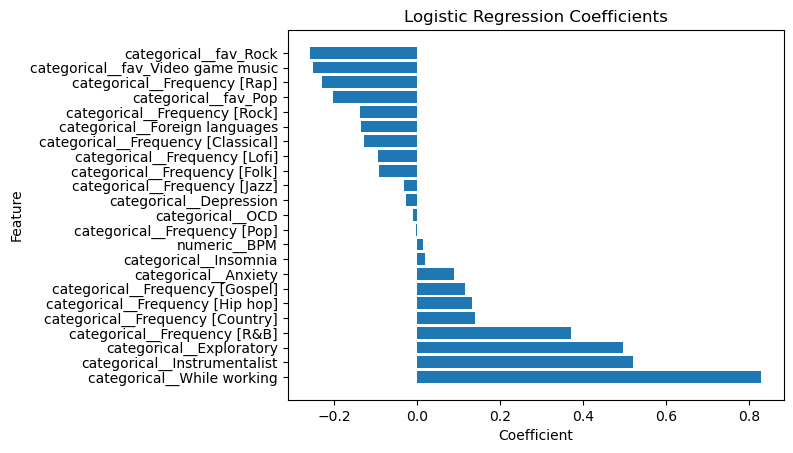

In [15]:
# Extract coefficients from logistic regression model
coefficients = lr_cv.best_estimator_.named_steps['classifier'].coef_[0]
features = lr_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
#features = features.replace('categorical__', '')
#features = features.replace('numeric__', '')

coef_df = pd.DataFrame({'Feature':features, 'Coefficient':coefficients}).sort_values(by='Coefficient', ascending=False)
relevant_coef = coef_df[coef_df['Coefficient'] != 0]

plt.barh(relevant_coef['Feature'], relevant_coef['Coefficient'])

plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

plt.show()